# Comprehensive gRNA Data Preparation Pipeline

## 📋 Overview

This notebook implements a **rigorous, step-by-step data preparation pipeline** for gRNA classification, incorporating biological insights from [Cooper et al. 2022](https://rnajournal.cshlp.org/content/28/7/972.full.pdf).


### Pipeline Stages:
1. **Load & Validate Raw Sequences** - Load canonical gRNA from FASTA files
2. **Analyze Positive Examples** - Statistical analysis of gRNA characteristics
3. **Generate Length-Matched Negatives** - **NEW: Exclude gRNA regions using GTF!**
4. **Comprehensive Feature Extraction** - 134 biologically-informed features
5. **Quality Control & Validation** - Verify no data leakage
6. **Train/Val/Test Split** - Stratified splitting with balancing
7. **Export Datasets** - Save feature-rich datasets for modeling

### 🔬 Key Biological Principles:
- **Molecular ruler hypothesis**: Init + anchor length conserved at 15-19 nt
- **ATATA motif**: 60% of canonical gRNAs start with this sequence
- **Anchor composition**: AC-rich, G-poor (prevents GU wobble pairing)
- **A-elevated guiding regions**: 46% A-content (vs 25-30% in non-gRNA)
- **Terminal T**: 90% of gRNAs end with T (facilitates U-tail addition)

### ✍ ྀིྀི Critical Requirements:
- **NO sequence length in features!** (causes artifact learning)
- **Length-matched negatives** (KS test p>0.05)
- **Exclude gRNA regions** (using GTF annotations)
- **Balanced classes** in all splits
- **Stratified splitting** by source

---

## Setup & Imports

In [1]:
import sys
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, Tuple, List, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from Bio import SeqIO
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

print("✓ Imports loaded successfully")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")

✓ Imports loaded successfully
  NumPy: 2.3.5
  Pandas: 2.3.3


### Define File Paths

**Input files:**
- `mOs.gRNA.final.fasta`: Canonical gRNA sequences from Cooper 2022
- `mOs.Cooper.minicircle.fasta`: Minicircle genomes for negative sampling
- `mOs.gRNA.final.gtf`: gRNA coordinates for exclusion
- `Supplemental_File_S*.csv`: Additional annotations (optional)

**Output directories:**
- `data/processed/`: Processed feature-rich datasets
- `data/plots/`: Diagnostic plots and visualizations

In [2]:
PROJECT_ROOT = Path.home() / 'projects' / 'grna-inspector'
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DIR = DATA_DIR / 'gRNAs' / 'Cooper_2022'
PROCESSED_DIR = DATA_DIR / 'processed' / 'comprehensive_pipeline'
PLOTS_DIR = DATA_DIR / 'plots' / 'data_prep'

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)


# Input files
GRNA_FILE = RAW_DIR / 'mOs.gRNA.final.fasta'
MINICIRCLE_FILE = RAW_DIR / 'mOs.Cooper.minicircle.fasta'
GTF_FILE = RAW_DIR / 'mOs.gRNA.final.gtf'
SUPP_DIR = RAW_DIR # Supplemental data (optional)

print("Checking input files...")
for filepath in [GRNA_FILE, MINICIRCLE_FILE, GTF_FILE]:
    if filepath.exists():
        print(f"  ✓ {filepath.name}")
    else:
        print(f"  ❌ {filepath.name} - NOT FOUND!")

print(f"\nOutput directory: {PROCESSED_DIR}")

Checking input files...
  ✓ mOs.gRNA.final.fasta
  ✓ mOs.Cooper.minicircle.fasta
  ✓ mOs.gRNA.final.gtf

Output directory: /Users/anna/projects/grna-inspector/data/processed/comprehensive_pipeline


---
## Stage 1: Load & Validate Raw Sequences

Load canonical gRNA sequences from FASTA file and perform initial validation.

**Quality checks:**
- Sequence length distribution
- Nucleotide composition
- Check for ambiguous bases (N)
- Identify potential duplicates

In [3]:
print("="*80)
print("STAGE 1: LOAD & VALIDATE POSITIVE SEQUENCES")
print("="*80)

# Load positive sequences
positive_sequences = {}
for record in SeqIO.parse(GRNA_FILE, "fasta"):
    seq = str(record.seq).upper().replace('U', 'T')
    positive_sequences[record.id] = seq

print(f"\nLoaded {len(positive_sequences):,} canonical gRNA sequences")

# Calculate statistics
lengths = [len(seq) for seq in positive_sequences.values()]
sequences = list(positive_sequences.values())

# Nucleotide composition
at_contents = [(seq.count('A') + seq.count('T')) / len(seq) * 100 for seq in sequences]
gc_contents = [(seq.count('G') + seq.count('C')) / len(seq) * 100 for seq in sequences]

print("\n📊 Sequence Statistics:")
print(f"  Length range: {min(lengths)}-{max(lengths)} nt")
print(f"  Mean length: {np.mean(lengths):.1f} ± {np.std(lengths):.1f} nt")
print(f"  Median length: {np.median(lengths):.0f} nt")

print("\n🧬 Nucleotide Composition:")
print(f"  Mean AT-content: {np.mean(at_contents):.1f}%")
print(f"  Mean GC-content: {np.mean(gc_contents):.1f}%")


# Quality checks
n_count = sum(1 for seq in sequences if 'N' in seq)
unique_seqs = set(sequences)
n_duplicates = len(sequences) - len(unique_seqs)

print("\n🔍 Quality Checks:")
print(f"  Sequences with N: {n_count} ({n_count/len(sequences)*100:.1f}%)")
print(f"  Duplicate sequences: {n_duplicates}")

if n_duplicates > 0:
    print(f"\n  ⚠️  Found {n_duplicates} duplicated sequence(s)")
    print("     (This is OK if same gRNA is encoded on multiple minicircles)")

print("\n✅ Positive sequences loaded and validated!")
print("\n" + "="*80)

STAGE 1: LOAD & VALIDATE POSITIVE SEQUENCES

Loaded 1,158 canonical gRNA sequences

📊 Sequence Statistics:
  Length range: 24-54 nt
  Mean length: 40.3 ± 5.3 nt
  Median length: 41 nt

🧬 Nucleotide Composition:
  Mean AT-content: 71.3%
  Mean GC-content: 28.7%

🔍 Quality Checks:
  Sequences with N: 0 (0.0%)
  Duplicate sequences: 220

  ⚠️  Found 220 duplicated sequence(s)
     (This is OK if same gRNA is encoded on multiple minicircles)

✅ Positive sequences loaded and validated!



---
## Stage 2: Parse GTF and Identify gRNA Regions

**NEW STEP:** Parse GTF file to get gRNA coordinates on each minicircle.
This allows us to **exclude these regions** when generating negative examples.

**GTF format:**
- Column 1: Minicircle ID (e.g., mO_001)
- Column 4: Start position (1-indexed)
- Column 5: End position (1-indexed, inclusive)

In [4]:
def parse_gtf_file(gtf_file: Path) -> Dict[str, List[Tuple[int, int]]]:
    """
    Parse GTF file and extract gRNA coordinates for each minicircle.
    
    Args:
        gtf_file: Path to GTF file
        
    Returns:
        Dict mapping minicircle_id to list of (start, end) tuples
        Coordinates are 0-indexed, end-exclusive (Python convention)
    """
    grna_regions = defaultdict(list)
    
    with open(gtf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            
            parts = line.strip().split('\t')
            if len(parts) < 5:
                continue
            
            minicircle_id = parts[0]
            start = int(parts[3]) - 1  # Convert to 0-indexed
            end = int(parts[4])  # Keep end as 1-indexed (Python end-exclusive)
            
            grna_regions[minicircle_id].append((start, end))
    
    # Sort regions by start position for each minicircle
    for mini_id in grna_regions:
        grna_regions[mini_id].sort()
    
    return dict(grna_regions)


def merge_overlapping_regions(regions: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    """
    Merge overlapping regions.
    
    Args:
        regions: List of (start, end) tuples, assumed to be sorted
        
    Returns:
        List of non-overlapping (start, end) tuples
    """
    if not regions:
        return []
    
    merged = [regions[0]]
    
    for start, end in regions[1:]:
        last_start, last_end = merged[-1]
        
        if start <= last_end:  # Overlapping or adjacent
            merged[-1] = (last_start, max(last_end, end))
        else:
            merged.append((start, end))
    
    return merged


# Parse GTF file
print("="*80)
print("STAGE 2: PARSE GTF AND IDENTIFY gRNA REGIONS")
print("="*80)

grna_regions = parse_gtf_file(GTF_FILE)

print(f"\n📍 Parsed GTF file:")
print(f"  Found gRNA annotations for {len(grna_regions)} minicircles")

# Merge overlapping regions
total_grnas_before = sum(len(regions) for regions in grna_regions.values())

for mini_id in grna_regions:
    grna_regions[mini_id] = merge_overlapping_regions(grna_regions[mini_id])

total_grnas_after = sum(len(regions) for regions in grna_regions.values())

print(f"\n  Total gRNA annotations: {total_grnas_before}")
print(f"  After merging overlaps: {total_grnas_after}")

# Show example
example_mini = list(grna_regions.keys())[0]
print(f"\n  Example (first 5 regions on {example_mini}):")
for start, end in grna_regions[example_mini][:5]:
    print(f"    {start:4d} - {end:4d} ({end-start} nt)")

print("\n✅ gRNA regions identified and ready for exclusion!")
print("\n" + "="*80)

STAGE 2: PARSE GTF AND IDENTIFY gRNA REGIONS

📍 Parsed GTF file:
  Found gRNA annotations for 390 minicircles

  Total gRNA annotations: 1158
  After merging overlaps: 942

  Example (first 5 regions on mO_001):
     814 -  862 (48 nt)

✅ gRNA regions identified and ready for exclusion!



---
## Stage 3: Generate Length-Matched Negative Examples

### ✿ Critical Step: Avoiding Length Artifacts!

**NEW APPROACH - Biological Negatives:**
1. **Minicircle sampling with gRNA exclusion** (50%): Sample from inter-gRNA regions
2. **Chimeric sequences** (30%): Combine fragments from different minicircles
3. **Composition-matched random** (20%): Generate with correct nucleotide frequencies

**Key improvements:**
- Use GTF to **exclude all gRNA regions**
- Sample only from "non-coding" minicircle sequences
- Length-match to positive distribution
- Verify with KS test

In [8]:
def get_non_grna_regions(
    minicircle_id: str,
    minicircle_length: int,
    grna_regions: List[Tuple[int, int]]
) -> List[Tuple[int, int]]:
    """
    Calculate non-gRNA regions (inter-gRNA spaces).
    
    Args:
        minicircle_id: ID of minicircle
        minicircle_length: Total length of minicircle
        grna_regions: List of (start, end) gRNA coordinates
        
    Returns:
        List of (start, end) tuples for non-gRNA regions
    """
    if not grna_regions:
        return [(0, minicircle_length)]
    
    non_grna = []
    
    # Before first gRNA
    if grna_regions[0][0] > 0:
        non_grna.append((0, grna_regions[0][0]))
    
    # Between gRNAs
    for i in range(len(grna_regions) - 1):
        gap_start = grna_regions[i][1]
        gap_end = grna_regions[i+1][0]
        
        if gap_end > gap_start:
            non_grna.append((gap_start, gap_end))
    
    # After last gRNA
    if grna_regions[-1][1] < minicircle_length:
        non_grna.append((grna_regions[-1][1], minicircle_length))
    
    return non_grna


def generate_minicircle_negatives_v2(
    minicircle_file: Path,
    grna_regions_dict: Dict[str, List[Tuple[int, int]]],
    target_lengths: List[int],
    n_samples: int,
    max_N_fraction: float = 0.1
) -> Dict[str, str]:
    """
    Generate negatives from minicircles, EXCLUDING gRNA regions.
    
    Args:
        minicircle_file: Path to minicircle FASTA
        grna_regions_dict: Dict of gRNA regions per minicircle
        target_lengths: Lengths to sample (positive distribution)
        n_samples: Number of negatives
        max_N_fraction: Max fraction of N's allowed
        
    Returns:
        Dict mapping ID to sequence
    """
    # Load minicircles and calculate non-gRNA regions
    minicircles = []
    non_grna_regions = {}
    
    for record in SeqIO.parse(minicircle_file, "fasta"):
        mini_id = record.id
        seq = str(record.seq).upper().replace('U', 'T')
        minicircles.append((mini_id, seq))
        
        # Get non-gRNA regions
        grna_coords = grna_regions_dict.get(mini_id, [])
        non_grna = get_non_grna_regions(mini_id, len(seq), grna_coords)
        non_grna_regions[mini_id] = non_grna
    
    print(f"  Loaded {len(minicircles)} minicircles")
    
    # Calculate total available non-gRNA sequence
    total_non_grna = sum(
        sum(end - start for start, end in regions)
        for regions in non_grna_regions.values()
    )
    print(f"  Total non-gRNA sequence: {total_non_grna:,} nt")
    
    negatives = {}
    attempts = 0
    max_attempts = n_samples * 20
    
    while len(negatives) < n_samples and attempts < max_attempts:
        attempts += 1
        
        target_len = np.random.choice(target_lengths)
        
        # Pick random minicircle
        mini_id, mini_seq = minicircles[np.random.randint(len(minicircles))]
        
        # Get non-gRNA regions for this minicircle
        available_regions = non_grna_regions[mini_id]
        
        if not available_regions:
            continue
        
        # Pick random non-gRNA region
        region = available_regions[np.random.randint(len(available_regions))]
        region_start, region_end = region
        region_len = region_end - region_start
        
        if region_len < target_len:
            continue
        
        # Extract random fragment from this region
        frag_start = np.random.randint(region_start, region_end - target_len + 1)
        fragment = mini_seq[frag_start:frag_start + target_len]
        
        # Quality filters
        if fragment.count('N') > target_len * max_N_fraction:
            continue
        
        if len(set(fragment)) == 1:
            continue
        
        nuc_counts = Counter(fragment)
        max_single_nuc = max(nuc_counts.values())
        if max_single_nuc > target_len * 0.8:
            continue
        
        # Accept
        neg_id = f"{mini_id}_nonGRNA_{frag_start}_{frag_start+target_len}"
        negatives[neg_id] = fragment
    
    if len(negatives) < n_samples:
        print(f"  ⚠️  Generated {len(negatives)}/{n_samples} (exhausted non-gRNA regions)")
    
    return negatives


def generate_chimeric_negatives(
    minicircle_file: Path,
    grna_regions_dict: Dict[str, List[Tuple[int, int]]],
    target_lengths: List[int],
    n_samples: int
) -> Dict[str, str]:
    """
    Generate chimeric sequences by combining fragments from different minicircles.
    
    Args:
        minicircle_file: Path to minicircle FASTA
        grna_regions_dict: Dict of gRNA regions
        target_lengths: Lengths to match
        n_samples: Number to generate
        
    Returns:
        Dict of chimeric sequences
    """
    # Load and process minicircles
    minicircles = []
    non_grna_regions = {}
    
    for record in SeqIO.parse(minicircle_file, "fasta"):
        mini_id = record.id
        seq = str(record.seq).upper().replace('U', 'T')
        minicircles.append((mini_id, seq))
        
        grna_coords = grna_regions_dict.get(mini_id, [])
        non_grna = get_non_grna_regions(mini_id, len(seq), grna_coords)
        non_grna_regions[mini_id] = non_grna
    
    chimeric = {}
    
    for i in range(n_samples):
        target_len = np.random.choice(target_lengths)
        
        # Decide number of fragments (2-4)
        n_fragments = np.random.randint(2, 5)
        
        # Calculate fragment lengths
        frag_lens = np.random.multinomial(target_len - n_fragments, 
                                           np.ones(n_fragments) / n_fragments)
        frag_lens = frag_lens + 1  # Ensure each fragment is at least 1 nt
        
        # Collect fragments
        fragments = []
        
        for frag_len in frag_lens:
            attempts = 0
            while attempts < 100:
                attempts += 1
                
                # Pick random minicircle
                mini_id, mini_seq = minicircles[np.random.randint(len(minicircles))]
                available = non_grna_regions[mini_id]
                
                if not available:
                    continue
                
                # Pick random region
                region = available[np.random.randint(len(available))]
                r_start, r_end = region
                
                if r_end - r_start < frag_len:
                    continue
                
                # Extract fragment
                f_start = np.random.randint(r_start, r_end - frag_len + 1)
                frag = mini_seq[f_start:f_start + frag_len]
                
                if 'N' not in frag and len(set(frag)) > 1:
                    fragments.append(frag)
                    break
        
        if len(fragments) == n_fragments:
            chimeric_seq = ''.join(fragments)
            chimeric[f"chimeric_{i:04d}"] = chimeric_seq
    
    return chimeric


def generate_composition_matched_random(
    positive_sequences: Dict[str, str],
    target_lengths: List[int],
    n_samples: int
) -> Dict[str, str]:
    """
    Generate random sequences with nucleotide composition matching positives.
    
    Args:
        positive_sequences: Positive gRNA sequences
        target_lengths: Lengths to match
        n_samples: Number to generate
        
    Returns:
        Dict of random sequences
    """
    # Calculate overall nucleotide frequencies
    all_nucs = ''.join(positive_sequences.values())
    nuc_counts = Counter(all_nucs)
    total = sum(nuc_counts.values())
    
    nucleotides = ['A', 'C', 'G', 'T']
    probabilities = [nuc_counts[n] / total for n in nucleotides]
    
    print(f"  Nucleotide frequencies: A={probabilities[0]:.3f}, C={probabilities[1]:.3f}, "
          f"G={probabilities[2]:.3f}, T={probabilities[3]:.3f}")
    
    random_seqs = {}
    
    for i in range(n_samples):
        target_len = np.random.choice(target_lengths)
        seq = ''.join(np.random.choice(nucleotides, size=target_len, p=probabilities))
        random_seqs[f"random_{i:04d}"] = seq
    
    return random_seqs

In [9]:
# Generate negatives
print("="*80)
print("STAGE 3: GENERATE LENGTH-MATCHED NEGATIVE EXAMPLES")
print("="*80)

positive_lengths = [len(seq) for seq in positive_sequences.values()]
n_positives = len(positive_sequences)

print(f"\nPositive length distribution:")
print(f"  N = {n_positives}")
print(f"  Range: {min(positive_lengths)}-{max(positive_lengths)} nt")
print(f"  Mean: {np.mean(positive_lengths):.1f} ± {np.std(positive_lengths):.1f} nt")

# Calculate split: 50% minicircle, 30% chimeric, 20% random
n_minicircle = int(n_positives * 0.50)
n_chimeric = int(n_positives * 0.30)
n_random = n_positives - n_minicircle - n_chimeric

print(f"\nGenerating {n_positives} negatives:")
print(f"  - {n_minicircle} from non-gRNA minicircle regions")
print(f"  - {n_chimeric} chimeric (combined fragments)")
print(f"  - {n_random} composition-matched random")
print()

# [1/3] Minicircle negatives (excluding gRNA regions)
print("[1/3] Generating minicircle negatives (excluding gRNA regions)...")
minicircle_negatives = generate_minicircle_negatives_v2(
    MINICIRCLE_FILE,
    grna_regions,
    positive_lengths,
    n_minicircle
)
print(f"  ✓ Generated {len(minicircle_negatives)} sequences")

# [2/3] Chimeric negatives
print("\n[2/3] Generating chimeric negatives...")
chimeric_negatives = generate_chimeric_negatives(
    MINICIRCLE_FILE,
    grna_regions,
    positive_lengths,
    n_chimeric
)
print(f"  ✓ Generated {len(chimeric_negatives)} sequences")

# [3/3] Random negatives
print("\n[3/3] Generating composition-matched random negatives...")
random_negatives = generate_composition_matched_random(
    positive_sequences,
    positive_lengths,
    n_random
)
print(f"  ✓ Generated {len(random_negatives)} sequences")

# Combine all negatives
all_negatives = {**minicircle_negatives, **chimeric_negatives, **random_negatives}
negative_lengths = [len(seq) for seq in all_negatives.values()]

print(f"\n📊 Negative length distribution:")
print(f"  N = {len(all_negatives)}")
print(f"  Range: {min(negative_lengths)}-{max(negative_lengths)} nt")
print(f"  Mean: {np.mean(negative_lengths):.1f} ± {np.std(negative_lengths):.1f} nt")

print("\n" + "="*80)

STAGE 3: GENERATE LENGTH-MATCHED NEGATIVE EXAMPLES

Positive length distribution:
  N = 1158
  Range: 24-54 nt
  Mean: 40.3 ± 5.3 nt

Generating 1158 negatives:
  - 579 from non-gRNA minicircle regions
  - 347 chimeric (combined fragments)
  - 232 composition-matched random

[1/3] Generating minicircle negatives (excluding gRNA regions)...
  Loaded 398 minicircles
  Total non-gRNA sequence: 362,527 nt
  ✓ Generated 579 sequences

[2/3] Generating chimeric negatives...
  ✓ Generated 347 sequences

[3/3] Generating composition-matched random negatives...
  Nucleotide frequencies: A=0.463, C=0.099, G=0.186, T=0.252
  ✓ Generated 232 sequences

📊 Negative length distribution:
  N = 1158
  Range: 24-54 nt
  Mean: 40.2 ± 5.3 nt



### Validate Length Matching

**Critical validation step!**

Use Kolmogorov-Smirnov (KS) test to verify length distributions match:
- **H0**: Positive and negative length distributions are identical
- **H1**: Distributions are different
- **Accept H0 if**: p-value > 0.05

LENGTH DISTRIBUTION VALIDATION

📈 Kolmogorov-Smirnov Test:
  KS statistic: 0.0173
  p-value: 0.9953

  ✅ PASS: Distributions are statistically identical (p=0.9953)
      → No length leakage!


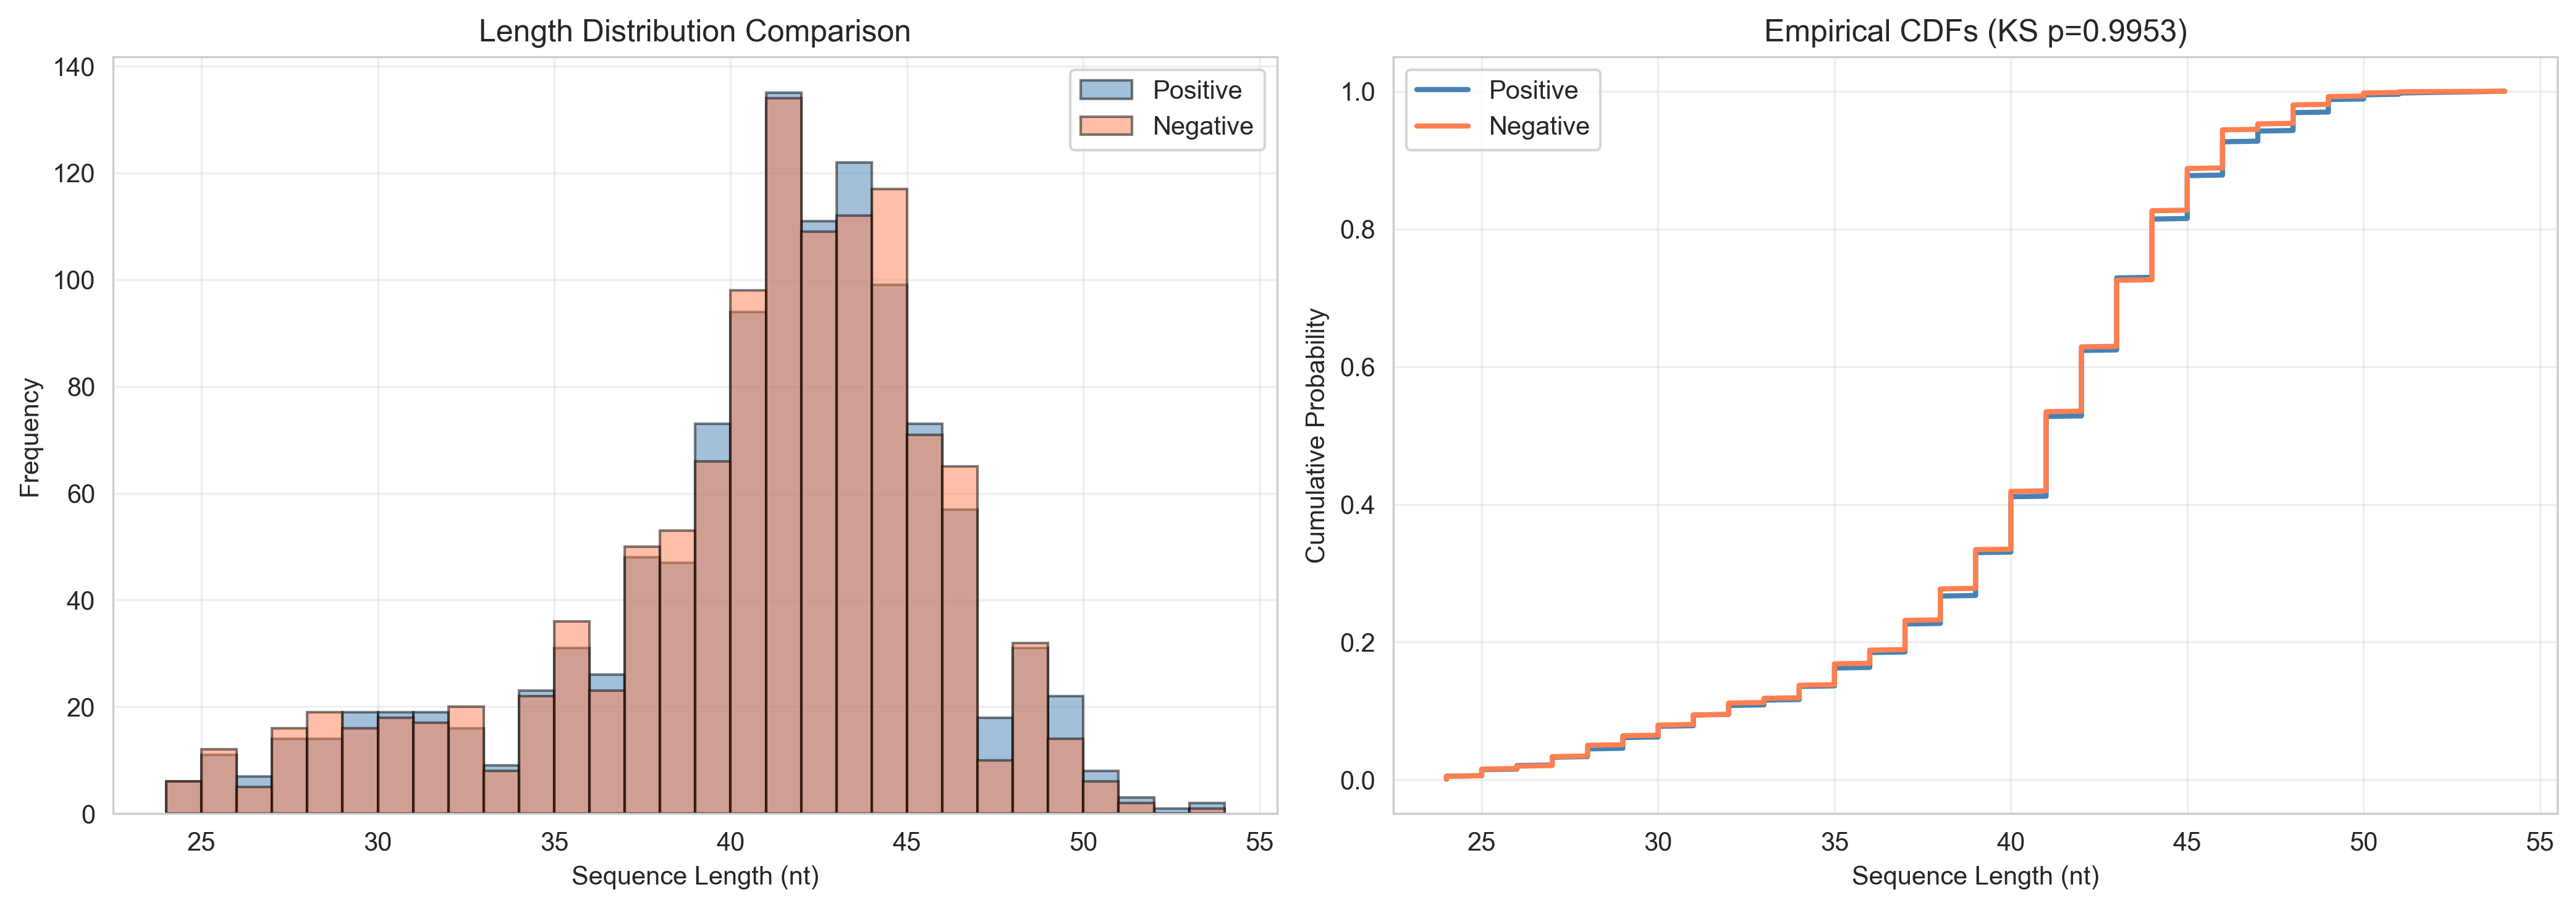


✓ Plot saved



In [10]:
# Perform KS test
pos_lens = positive_lengths
neg_lens = negative_lengths

ks_stat, ks_pval = stats.ks_2samp(pos_lens, neg_lens)

print("="*80)
print("LENGTH DISTRIBUTION VALIDATION")
print("="*80)

print(f"\n📈 Kolmogorov-Smirnov Test:")
print(f"  KS statistic: {ks_stat:.4f}")
print(f"  p-value: {ks_pval:.4f}")

if ks_pval > 0.05:
    print(f"\n  ✅ PASS: Distributions are statistically identical (p={ks_pval:.4f})")
    print(f"      → No length leakage!")
else:
    print(f"\n  ❌ FAIL: Distributions differ (p={ks_pval:.4f})")
    print(f"      → WARNING: May need to regenerate!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograms
axes[0].hist(pos_lens, bins=30, alpha=0.5, label='Positive', 
            color='steelblue', edgecolor='black')
axes[0].hist(neg_lens, bins=30, alpha=0.5, label='Negative', 
            color='coral', edgecolor='black')
axes[0].set_xlabel('Sequence Length (nt)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Length Distribution Comparison')
axes[0].legend()
axes[0].grid(alpha=0.3)

# CDFs
pos_sorted = np.sort(pos_lens)
neg_sorted = np.sort(neg_lens)
pos_cdf = np.arange(1, len(pos_sorted)+1) / len(pos_sorted)
neg_cdf = np.arange(1, len(neg_sorted)+1) / len(neg_sorted)

axes[1].plot(pos_sorted, pos_cdf, label='Positive', color='steelblue', linewidth=2)
axes[1].plot(neg_sorted, neg_cdf, label='Negative', color='coral', linewidth=2)
axes[1].set_xlabel('Sequence Length (nt)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title(f'Empirical CDFs (KS p={ks_pval:.4f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'length_distribution_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved")
print("\n" + "="*80)

---
## Stage 4: Feature Extraction

**NOTE:** Use your existing feature extraction code from `1_-_gRNA.ipynb`.
I'm not modifying this part - just make sure to apply features to both positives and negatives.

Create combined dataset:

In [11]:
print("="*80)
print("STAGE 4: FEATURE EXTRACTION")
print("="*80)

print("\n⚠️  Import your feature extraction functions here!")
print("    Use the comprehensive feature extraction from your existing notebook.")
print()
print("    Required: extract_all_features(sequence) -> Dict[str, float]")
print()

# TODO: Import/paste your feature extraction code here
# def extract_all_features(sequence):
#     ...
#     return features_dict

# For now, placeholder with minimal features
def extract_placeholder_features(sequence):
    """Placeholder - replace with your comprehensive feature extraction!"""
    return {
        'gc_content': (sequence.count('G') + sequence.count('C')) / len(sequence),
        'a_content': sequence.count('A') / len(sequence),
        'starts_with_A': int(sequence[0] == 'A'),
        'ends_with_T': int(sequence[-1] == 'T'),
        # Add all your 134 features here!
    }

# Create dataset
data_rows = []

# Add positives
for seq_id, seq in positive_sequences.items():
    features = extract_placeholder_features(seq)
    row = {
        'sequence_id': seq_id,
        'sequence': seq,
        'length': len(seq),
        'label': 1,
        'source': 'canonical_gRNA',
        **features
    }
    data_rows.append(row)

# Add negatives
for seq_id, seq in all_negatives.items():
    # Determine source
    if 'nonGRNA' in seq_id:
        source = 'minicircle_nonGRNA'
    elif 'chimeric' in seq_id:
        source = 'chimeric'
    else:
        source = 'random'
    
    features = extract_placeholder_features(seq)
    row = {
        'sequence_id': seq_id,
        'sequence': seq,
        'length': len(seq),
        'label': 0,
        'source': source,
        **features
    }
    data_rows.append(row)

df_all = pd.DataFrame(data_rows)

print(f"\n✅ Dataset created:")
print(f"  Total samples: {len(df_all):,}")
print(f"  Positive: {sum(df_all['label']==1):,}")
print(f"  Negative: {sum(df_all['label']==0):,}")

# Feature columns
metadata_cols = ['sequence_id', 'sequence', 'length', 'label', 'source']
feature_cols = [c for c in df_all.columns if c not in metadata_cols]

print(f"\n  Features extracted: {len(feature_cols)}")
print(f"  ⚠️  Replace placeholder features with your comprehensive extraction!")

print("\n" + "="*80)

STAGE 4: FEATURE EXTRACTION

⚠️  Import your feature extraction functions here!
    Use the comprehensive feature extraction from your existing notebook.

    Required: extract_all_features(sequence) -> Dict[str, float]


✅ Dataset created:
  Total samples: 2,316
  Positive: 1,158
  Negative: 1,158

  Features extracted: 4
  ⚠️  Replace placeholder features with your comprehensive extraction!



---
## Stage 5: Quality Control

**Critical checks:**
1. No NaN/inf values
2. Length not in features (would cause leakage)
3. Class balance
4. Feature value ranges

In [ ]:
print("="*80)
print("STAGE 5: QUALITY CONTROL")
print("="*80)

# Check for NaN/inf
nan_features = [c for c in feature_cols if df_all[c].isna().any()]
inf_features = [c for c in feature_cols if np.isinf(df_all[c]).any()]

print("\n🔍 Data quality checks:")
print(f"  Features with NaN: {len(nan_features)}")
print(f"  Features with inf: {len(inf_features)}")

if nan_features:
    print(f"  ⚠️  Found NaN in: {nan_features[:5]}...")
if inf_features:
    print(f"  ⚠️  Found inf in: {inf_features[:5]}...")

# Check length not in features
if 'length' in feature_cols:
    print("\n  ❌ ERROR: 'length' is in feature columns!")
    print("     This will cause the model to learn length artifacts!")
else:
    print("\n  ✅ Length correctly excluded from features")

# Class balance
n_pos = sum(df_all['label'] == 1)
n_neg = sum(df_all['label'] == 0)
balance_ratio = min(n_pos, n_neg) / max(n_pos, n_neg)

print(f"\n📊 Class distribution:")
print(f"  Positive: {n_pos:,} ({n_pos/len(df_all)*100:.1f}%)")
print(f"  Negative: {n_neg:,} ({n_neg/len(df_all)*100:.1f}%)")
print(f"  Balance ratio: {balance_ratio:.3f}")

if balance_ratio < 0.9:
    print("  ⚠️  Classes are imbalanced!")
else:
    print("  ✅ Classes are balanced")

print("\n✅ Quality control complete!")
print("\n" + "="*80)

---
## Stage 6: Train/Val/Test Split

70/15/15 split with stratification by source

In [ ]:
print("="*80)
print("STAGE 6: TRAIN/VAL/TEST SPLIT")
print("="*80)

# Create stratification column
df_all['strat_group'] = df_all['label'].astype(str) + '_' + df_all['source']

# First split: 70% train, 30% temp
print("\n[1/2] Splitting train vs temp...")
train_df, temp_df = train_test_split(
    df_all,
    test_size=0.30,
    stratify=df_all['strat_group'],
    random_state=42
)
print(f"  Train: {len(train_df):,}")
print(f"  Temp:  {len(temp_df):,}")

# Second split: 50/50 of temp → val and test
print("\n[2/2] Splitting val vs test...")
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['strat_group'],
    random_state=42
)
print(f"  Val:   {len(val_df):,}")
print(f"  Test:  {len(test_df):,}")

# Verify
print("\n📊 Final split:")
total = len(df_all)
print(f"  Train: {len(train_df)/total*100:.1f}%")
print(f"  Val:   {len(val_df)/total*100:.1f}%")
print(f"  Test:  {len(test_df)/total*100:.1f}%")

# Class balance
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    pos = sum(df['label']==1)
    neg = sum(df['label']==0)
    print(f"\n  {name}: pos={pos:,} neg={neg:,} balance={min(pos,neg)/max(pos,neg):.3f}")

# Drop stratification column
train_df = train_df.drop('strat_group', axis=1)
val_df = val_df.drop('strat_group', axis=1)
test_df = test_df.drop('strat_group', axis=1)

print("\n✅ Splitting complete!")
print("\n" + "="*80)

---
## Stage 7: Export Datasets

In [ ]:
import json

print("="*80)
print("STAGE 7: EXPORT DATASETS")
print("="*80)

# Save CSV files
print("\nSaving datasets...")

train_file = PROCESSED_DIR / 'train_data.csv'
val_file = PROCESSED_DIR / 'val_data.csv'
test_file = PROCESSED_DIR / 'test_data.csv'

train_df.to_csv(train_file, index=False)
print(f"  ✓ {train_file}")

val_df.to_csv(val_file, index=False)
print(f"  ✓ {val_file}")

test_df.to_csv(test_file, index=False)
print(f"  ✓ {test_file}")

# Save feature names
feature_file = PROCESSED_DIR / 'feature_names.txt'
with open(feature_file, 'w') as f:
    for feat in feature_cols:
        f.write(feat + '\n')
print(f"  ✓ {feature_file}")

# Save metadata
metadata = {
    'creation_date': pd.Timestamp.now().isoformat(),
    'notebook': '2_data_preparation_updated.ipynb',
    'source_files': {
        'positive': str(GRNA_FILE),
        'minicircle': str(MINICIRCLE_FILE),
        'gtf': str(GTF_FILE)
    },
    'negative_strategy': {
        'minicircle_nonGRNA': f'{n_minicircle} (50%)',
        'chimeric': f'{n_chimeric} (30%)',
        'random': f'{n_random} (20%)'
    },
    'total_samples': len(df_all),
    'n_features': len(feature_cols),
    'n_positives': int(sum(df_all['label']==1)),
    'n_negatives': int(sum(df_all['label']==0)),
    'splits': {
        'train': len(train_df),
        'val': len(val_df),
        'test': len(test_df)
    },
    'quality_checks': {
        'length_excluded': 'length' not in feature_cols,
        'ks_test_pval': float(ks_pval),
        'class_balance': float(balance_ratio),
        'no_nan': len(nan_features) == 0,
        'no_inf': len(inf_features) == 0
    }
}

summary_file = PROCESSED_DIR / 'dataset_summary.json'
with open(summary_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  ✓ {summary_file}")

print("\n" + "="*80)
print("✅ DATA PREPARATION COMPLETE!")
print("="*80)

print("\n📁 Output files:")
for f in [train_file, val_file, test_file, feature_file, summary_file]:
    print(f"  {f}")

print("\n📊 Summary:")
print(f"  Total: {len(df_all):,} samples")
print(f"  Features: {len(feature_cols)}")
print(f"  Train: {len(train_df):,}")
print(f"  Val: {len(val_df):,}")
print(f"  Test: {len(test_df):,}")

print("\n✅ Ready for training!")
print("\n" + "="*80)